In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from pprint import pprint
import re
import json
import gzip
class LTEParser:
    @staticmethod
    def parse(inFile, flowDuration = 100):
        videoAverages = []
        videoFairness = []
        videoDelay = []
        videoJitter = []
        voiceAverages = []
        voiceFairness = []
        voiceDelay = []
        voiceJitter = []
        packetLoss = []
        for sfile in inFile:
            content = ""
            print("Opening file: " + sfile)
            with gzip.open(sfile, 'rb') as file:
                content = file.read()
                content = content.decode('utf-8')
            print("Parsing file ...", end="")
            txContent, rxContent = LTEParser._parse(content)
            info = LTEParser.getFairnessIndex(rxContent, flowDuration)
            packetLossInfo = LTEParser.getPacketLossRatio(txContent, rxContent)
            delayInfo = LTEParser.getDelayJitter(rxContent)
            videoAverages.append(info['VIDEO']['Average'])
            videoFairness.append(info['VIDEO']['FairnessIndex'])
            videoDelay.append(delayInfo['VIDEO']['Average'])
            videoJitter.append(delayInfo['VIDEO']['StD'])
            voiceAverages.append(info['VOIP']['Average'])
            voiceFairness.append(info['VOIP']['FairnessIndex'])
            voiceDelay.append(delayInfo['VOIP']['Average'])
            voiceJitter.append(delayInfo['VOIP']['StD'])
            packetLoss.append(packetLossInfo)
        return [(sum(videoAverages)/len(videoAverages)),
                (sum(videoFairness)/len(videoFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                (sum(voiceAverages)/len(voiceAverages)),
                (sum(voiceFairness)/len(voiceFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                packetLoss]
    @staticmethod
    def _parse(content):
        txContent = LTEParser.parseTX(content)
        rxContent = LTEParser.parseRX(content)
        print("Done")
        return txContent, rxContent
    
    @staticmethod
    def parseTX(content):
        _mapa = {
            "B": "#Bearer",
            "T": "TimeStamp",
            "TX": "Transmission",
            "RX": "Receiver",
            "D": "Delay",
            "ID": "#Packet",
            "DST": "Destiny",
            "SRC": "Source",
            "SIZE": "Size"
        }
        matches = re.findall("(TX.+)", content)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        for match in matches:
            values = match.split(' ')
            tamanho = len(values)
            dic = {}
            for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                dic[_mapa[values[i]]] = values[i+1]
            dic = dict(sorted(dic.items(), key=lambda x: x[0]))
            dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
        
    @staticmethod        
    def parseRX(content):
        _mapa = {
            "B": "#Bearer",
            "T": "TimeStamp",
            "TX": "Transmission",
            "RX": "Receiver",
            "D": "Delay",
            "ID": "#Packet",
            "DST": "Destiny",
            "SRC": "Source",
            "SIZE": "Size"
        }
        matches = re.findall("(RX.+)", content)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        for match in matches:
            values = match.split(' ')
            tamanho = len(values)
            dic = {}
            for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                dic[_mapa[values[i]]] = values[i+1]
            dic = dict(sorted(dic.items(), key=lambda x: x[0]))
            dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
    
    @staticmethod
    def getPacketLossRatio(txContent, rxContent):
        tx_pkts = 0
        rx_pkts = 0
        for key in txContent:
            tx_pkts += len(txContent[key])
        for key in rxContent:
            rx_pkts += len(rxContent[key])
        plr = ((tx_pkts - rx_pkts) / tx_pkts) * 100
        return plr
    
    @staticmethod
    def getDelayJitter(rxContent):
        delayPerApp = {}
        for app in rxContent:
            delayPerApp[app] = {"Sum": 0, "Average": 0, "StD": 0}
            delayPerApp[app]["Sum"] = sum(float(item["Delay"]) for item in rxContent[app])
            tamanho = len(rxContent[app])
            delayPerApp[app]["Average"] = delayPerApp[app]["Sum"]/tamanho if tamanho != 0 else 0
            delayPerApp[app]["StD"] = sum((float(item["Delay"]) - delayPerApp[app]["Average"])**2 for item in rxContent[app])/ (tamanho - 1) if tamanho != 0 else 0
        return delayPerApp
    
    @staticmethod
    def getGoodput(rxContent, flowDuration):
        gputPerApp = {}
        for app in rxContent:
            gputPerApp[app] = {"Sum": 0, "Average": 0}
            gputPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
            gputPerApp[app]["Average"] = (gputPerApp[app]["Sum"]/125000)/flowDuration
        return gputPerApp
    
    @staticmethod
    def getThroughput(rxContent, flowDuration):
        tputPerApp = {}
        for app in rxContent:
            tputPerApp[app] = {"Sum": 0, "Average": 0}
            tputPerApp[app]["Sum"] = sum((float(item["Size"]) + 5)*8 for item in rxContent[app])
            tputPerApp[app]["Average"] = (tputPerApp[app]["Sum"]/125000)/flowDuration
        return tputPerApp
    
    @staticmethod
    def getFairnessIndex(rxContent, flowDuration):
        fairnessPerApp = {}
        for app in rxContent:
            fairnessPerApp[app] = {"Sum": 0, "Average": 0, "SumSquared": 0, "SquaredSum": 0, "FairnessIndex": 0}
            if(len(rxContent[app]) > 0):
                fairnessPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
                fairnessPerApp[app]["Average"] = (fairnessPerApp[app]["Sum"]/125000)/flowDuration
                fairnessPerApp[app]["SumSquared"] = sum(pow(float(item["Size"])*8,2) for item in rxContent[app])
                fairnessPerApp[app]["SquaredSum"] = pow(fairnessPerApp[app]["Sum"], 2)
                division = (len(rxContent[app]) * fairnessPerApp[app]["SumSquared"])
                fairnessPerApp[app]["FairnessIndex"] = fairnessPerApp[app]["SquaredSum"] / division if division > 0 else 1
        return fairnessPerApp

In [43]:
base = "../../../Simulations/Raw/Interference_2"
ext = ".gz"
until = 3
files = {1: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         2: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         3: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         4: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         5: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         6: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}}}
for sched in range(1,7):
    for ue in range(20, 101, 10):
        for vel in [30, 120]:
            for count in range(1,until):
                file = "/SCHED_" + str(sched) + "_UE_" + str(ue) + "_V_" + str(vel) +"_D_0.1_" + str(count)
                filename = base + file + ext
                files[sched][vel][ue].append(filename)

In [44]:
pprint(files)

{1: {30: {20: ['../../../Simulations/Raw/Interference_2/SCHED_1_UE_20_V_30_D_0.1_1.gz',
               '../../../Simulations/Raw/Interference_2/SCHED_1_UE_20_V_30_D_0.1_2.gz'],
          30: ['../../../Simulations/Raw/Interference_2/SCHED_1_UE_30_V_30_D_0.1_1.gz',
               '../../../Simulations/Raw/Interference_2/SCHED_1_UE_30_V_30_D_0.1_2.gz'],
          40: ['../../../Simulations/Raw/Interference_2/SCHED_1_UE_40_V_30_D_0.1_1.gz',
               '../../../Simulations/Raw/Interference_2/SCHED_1_UE_40_V_30_D_0.1_2.gz'],
          50: ['../../../Simulations/Raw/Interference_2/SCHED_1_UE_50_V_30_D_0.1_1.gz',
               '../../../Simulations/Raw/Interference_2/SCHED_1_UE_50_V_30_D_0.1_2.gz'],
          60: ['../../../Simulations/Raw/Interference_2/SCHED_1_UE_60_V_30_D_0.1_1.gz',
               '../../../Simulations/Raw/Interference_2/SCHED_1_UE_60_V_30_D_0.1_2.gz'],
          70: ['../../../Simulations/Raw/Interference_2/SCHED_1_UE_70_V_30_D_0.1_1.gz',
               '../../../Si

# Proportional and Fair - 30KM/H

In [5]:
GPUTSVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
GPUTSVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PACKETLOSS = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    for ue in range(20, 101, 10):
        info = LTEParser.parse(files[sched][30][ue], 100)
        GPUTSVIDEO[sched].append(info[0])
        FAIRVIDEO[sched].append(info[1])
        DELAYVIDEO[sched].append(info[2])
        JITTERVIDEO[sched].append(info[3])
        GPUTSVOICE[sched].append(info[4])
        FAIRVOICE[sched].append(info[5])
        DELAYVOICE[sched].append(info[6])
        JITTERVOICE[sched].append(info[7])
        PACKETLOSS[sched].append(info[8])
    GPUTSVIDEO[sched] = np.array(GPUTSVIDEO[sched], dtype=np.float32)
    FAIRVIDEO[sched] = np.array(FAIRVIDEO[sched], dtype=np.float32)
    DELAYVIDEO[sched] = np.array(DELAYVIDEO[sched], dtype = np.float32)
    JITTERVIDEO[sched] = np.array(JITTERVIDEO[sched], dtype = np.float32)
    GPUTSVOICE[sched] = np.array(GPUTSVOICE[sched], dtype=np.float32)
    FAIRVOICE[sched] = np.array(FAIRVOICE[sched], dtype=np.float32)
    DELAYVOICE[sched] = np.array(DELAYVOICE[sched], dtype = np.float32)
    JITTERVOICE[sched] = np.array(JITTERVOICE[sched], dtype = np.float32)
    PACKETLOSS[sched] = np.array(PACKETLOSS[sched], dtype=np.float32)

Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_20_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_20_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_30_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_30_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_40_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_40_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_50_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_50_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_60_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/S

Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_50_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_50_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_60_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_60_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_70_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_70_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_80_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_80_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_90_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations

# VIDEO GPUT MB/s

In [6]:
MEGAVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    MEGAVIDEO[sched] = np.true_divide(GPUTSVIDEO[sched], 8)
MEGAVIDEO

{1: array([2.8196132, 1.5195911, 1.0476191, 1.194533 , 1.1467818, 1.2471982,
        1.1242313, 1.1507871, 1.2799366], dtype=float32),
 2: array([3.8790686, 4.560423 , 4.461217 , 4.291248 , 4.0333786, 3.765283 ,
        3.3407366, 2.8493588, 2.8237739], dtype=float32),
 3: array([3.9747474, 4.382265 , 4.312328 , 3.8375611, 3.4853966, 3.2202237,
        3.0100226, 2.8196435, 2.859403 ], dtype=float32),
 4: array([4.8587804, 7.1587105, 8.831927 , 9.405493 , 9.661802 , 9.067041 ,
        8.471028 , 7.5593014, 7.0658703], dtype=float32),
 5: array([4.765389 , 6.59207  , 7.344764 , 7.025937 , 6.164172 , 5.5033884,
        5.0666447, 4.416031 , 4.08947  ], dtype=float32),
 6: array([3.8777494, 4.3814473, 4.6150374, 4.077805 , 3.9493868, 3.5686681,
        3.405612 , 2.9919379, 2.671394 ], dtype=float32)}

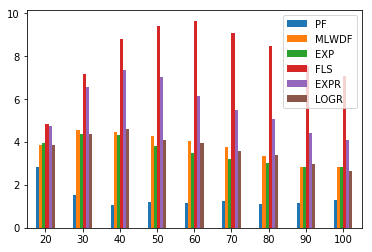

In [29]:
dfGPUTVIDEO = pd.DataFrame({'PF': MEGAVIDEO[1], 'MLWDF': MEGAVIDEO[2], 'EXP': MEGAVIDEO[3],
                       'FLS': MEGAVIDEO[4], 'EXPR': MEGAVIDEO[5], 'LOGR': MEGAVIDEO[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVideo.pdf", bbox_inches='tight')

In [8]:
dfGPUTVIDEO

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,2.819613,3.879069,3.974747,4.858780,4.765389,3.877749
30,1.519591,4.560423,4.382265,7.158710,6.592070,4.381447
40,1.047619,4.461217,4.312328,8.831927,7.344764,4.615037
50,1.194533,4.291248,3.837561,9.405493,7.025937,4.077805
60,1.146782,4.033379,3.485397,9.661802,6.164172,3.949387
70,1.247198,3.765283,3.220224,9.067041,5.503388,3.568668
80,1.124231,3.340737,3.010023,8.471028,5.066645,3.405612
90,1.150787,2.849359,2.819643,7.559301,4.416031,2.991938
100,1.279937,2.823774,2.859403,7.065870,4.089470,2.671394


# Delay Jitter

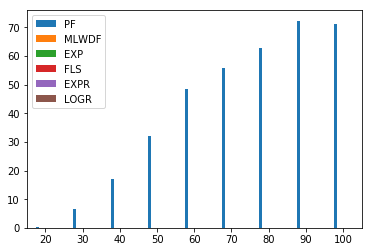

In [30]:
dfDELAYVIDEO = pd.DataFrame({'PF': DELAYVIDEO[1], 'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideoPF.pdf", bbox_inches='tight')

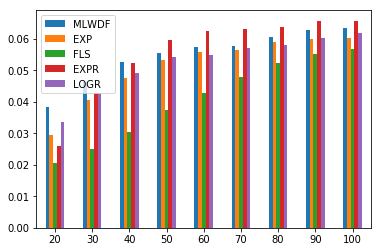

In [31]:
dfDELAYVIDEO = pd.DataFrame({'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideo.pdf", bbox_inches='tight')

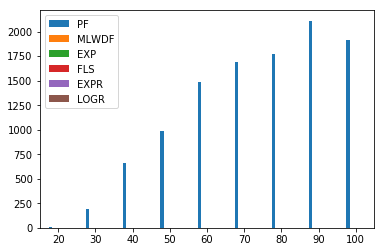

In [32]:
dfJITTERVIDEO = pd.DataFrame({'PF': JITTERVIDEO[1], 'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideoPF.pdf", bbox_inches='tight')

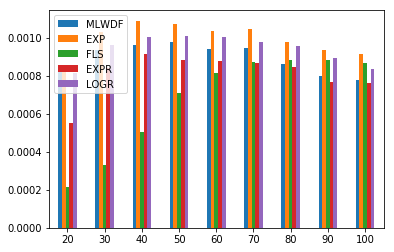

In [33]:
dfJITTERVIDEO = pd.DataFrame({'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideo.pdf", bbox_inches='tight')

# VIDEO FAIRNESS

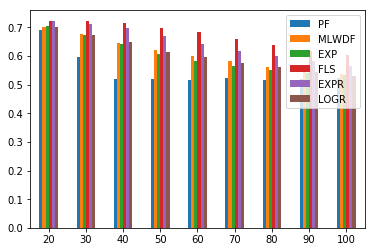

In [34]:
dfFAIRVIDEO = pd.DataFrame({'PF': FAIRVIDEO[1], 'MLWDF': FAIRVIDEO[2], 'EXP': FAIRVIDEO[3],
                            'FLS': FAIRVIDEO[4], 'EXPR': FAIRVIDEO[5], 'LOGR': FAIRVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfFAIRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVideo.pdf", bbox_inches='tight')

In [14]:
dfFAIRVIDEO

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,0.692351,0.701294,0.703106,0.723149,0.721161,0.701116
30,0.596318,0.677704,0.672789,0.721318,0.713325,0.673424
40,0.519932,0.646864,0.641459,0.713644,0.696067,0.648452
50,0.518844,0.620790,0.608045,0.698077,0.670618,0.615126
60,0.516635,0.600519,0.583083,0.681994,0.642097,0.594952
70,0.521712,0.582137,0.564842,0.660306,0.617762,0.576500
80,0.515689,0.562002,0.551071,0.639331,0.599213,0.561144
90,0.519860,0.543403,0.538916,0.618623,0.581384,0.542674
100,0.522817,0.536025,0.534845,0.603893,0.566426,0.530259


# VOIP GPUT MB/s

In [17]:
MEGAVOIP = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVOICE:
    MEGAVOIP[sched] = np.true_divide(GPUTSVOICE[sched], 8)
MEGAVOIP

{1: array([0.15258113, 0.22733824, 0.30227968, 0.36957183, 0.45309696,
        0.53431296, 0.6138624 , 0.66985214, 0.7405312 ], dtype=float32),
 2: array([0.15545088, 0.21860352, 0.30423808, 0.37755647, 0.46146816,
        0.52180994, 0.6159258 , 0.6776499 , 0.7357952 ], dtype=float32),
 3: array([0.15730432, 0.22601728, 0.29678848, 0.3862221 , 0.45541632,
        0.5180134 , 0.59363586, 0.6831846 , 0.73119485], dtype=float32),
 4: array([0.15123712, 0.22996736, 0.29602304, 0.37589505, 0.45755392,
        0.53708035, 0.5975142 , 0.68718594, 0.7562573 ], dtype=float32),
 5: array([0.15371776, 0.21533953, 0.3013888 , 0.38133505, 0.454976  ,
        0.53562367, 0.6012339 , 0.6840115 , 0.7392051 ], dtype=float32),
 6: array([0.15180545, 0.22458369, 0.3046323 , 0.37265408, 0.4552704 ,
        0.53167105, 0.6027187 , 0.6666624 , 0.7368832 ], dtype=float32)}

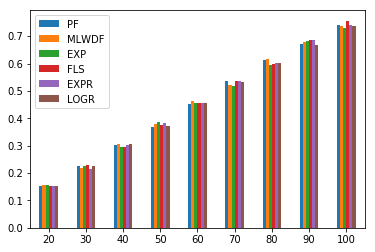

In [35]:
dfGPUTVOICE = pd.DataFrame({'PF': MEGAVOIP[1], 'MLWDF': MEGAVOIP[2], 'EXP': MEGAVOIP[3],
                       'FLS': MEGAVOIP[4], 'EXPR': MEGAVOIP[5], 'LOGR': MEGAVOIP[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVoIP.pdf", bbox_inches='tight')

In [18]:
dfGPUTVOICE

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,0.152581,0.155451,0.157304,0.151237,0.153718,0.151805
30,0.227338,0.218604,0.226017,0.229967,0.215340,0.224584
40,0.302280,0.304238,0.296788,0.296023,0.301389,0.304632
50,0.369572,0.377556,0.386222,0.375895,0.381335,0.372654
60,0.453097,0.461468,0.455416,0.457554,0.454976,0.455270
70,0.534313,0.521810,0.518013,0.537080,0.535624,0.531671
80,0.613862,0.615926,0.593636,0.597514,0.601234,0.602719
90,0.669852,0.677650,0.683185,0.687186,0.684012,0.666662
100,0.740531,0.735795,0.731195,0.756257,0.739205,0.736883


# Delay Jitter

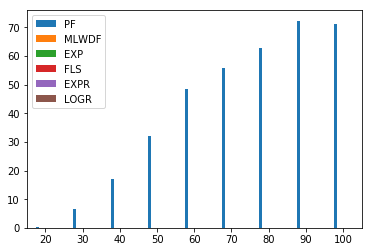

In [36]:
dfDELAYVOICE = pd.DataFrame({'PF': DELAYVOICE[1], 'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIPPF.pdf", bbox_inches='tight')

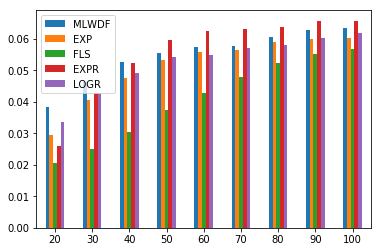

In [37]:
dfDELAYVOICE = pd.DataFrame({'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIP.pdf", bbox_inches='tight')

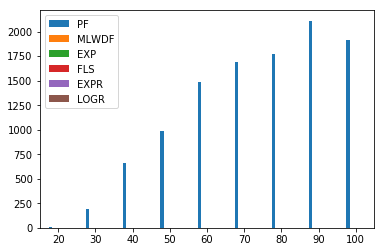

In [38]:
dfJITTERVOICE = pd.DataFrame({'PF': JITTERVOICE[1], 'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIPPF.pdf", bbox_inches='tight')

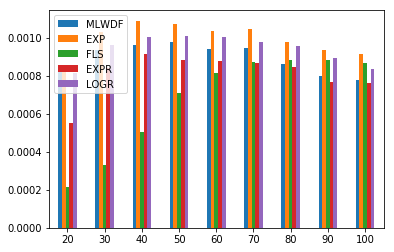

In [39]:
dfJITTERVOICE = pd.DataFrame({'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIP.pdf", bbox_inches='tight')

# Loss Ratio

In [23]:
averagePacketLoss = {}
for key in PACKETLOSS:
    averagePacketLoss[key] = []
    for i in range(0, 9):
        average = sum(PACKETLOSS[key][i])/len(PACKETLOSS[key][i])         
        averagePacketLoss[key].append(average)

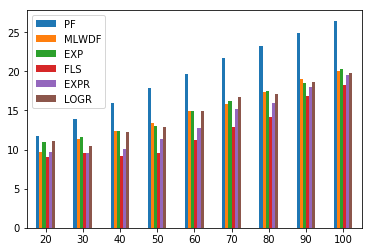

In [40]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1], 'MLWDF': averagePacketLoss[2], 'EXP': averagePacketLoss[3],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfLossRatio.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio.pdf", bbox_inches='tight')

In [25]:
dfLossRatio

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,11.696552,9.657321,11.001947,9.048378,9.660849,11.160954
30,13.959570,11.395448,11.638498,9.537148,9.569852,10.500238
40,15.902214,12.369527,12.391129,9.241488,10.030218,12.255569
50,17.841066,13.421984,13.019650,9.543735,11.374303,12.910537
60,19.653223,14.996969,14.930842,11.171062,12.797309,14.913518
70,21.757280,15.816453,16.154774,12.936624,15.224308,16.740196
80,23.237684,17.376478,17.483644,14.201983,15.954392,17.066929
90,24.910725,18.976112,18.488905,16.810257,18.013855,18.669764
100,26.477448,20.055994,20.350304,18.276794,19.498676,19.831911


In [45]:
GPUTSVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
GPUTSVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PACKETLOSS120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    for ue in range(20, 101, 10):
        info = LTEParser.parse(files[sched][120][ue], 100)
        GPUTSVIDEO120[sched].append(info[0])
        FAIRVIDEO120[sched].append(info[1])
        DELAYVIDEO120[sched].append(info[2])
        JITTERVIDEO120[sched].append(info[3])
        GPUTSVOICE120[sched].append(info[4])
        FAIRVOICE120[sched].append(info[5])
        DELAYVOICE120[sched].append(info[6])
        JITTERVOICE120[sched].append(info[7])
        PACKETLOSS120[sched].append(info[8])
    GPUTSVIDEO120[sched] = np.array(GPUTSVIDEO120[sched], dtype=np.float32)
    FAIRVIDEO120[sched] = np.array(FAIRVIDEO120[sched], dtype=np.float32)
    DELAYVIDEO120[sched] = np.array(DELAYVIDEO120[sched], dtype = np.float32)
    JITTERVIDEO120[sched] = np.array(JITTERVIDEO120[sched], dtype = np.float32)
    GPUTSVOICE120[sched] = np.array(GPUTSVOICE120[sched], dtype=np.float32)
    FAIRVOICE120[sched] = np.array(FAIRVOICE120[sched], dtype=np.float32)
    DELAYVOICE120[sched] = np.array(DELAYVOICE120[sched], dtype = np.float32)
    JITTERVOICE120[sched] = np.array(JITTERVOICE120[sched], dtype = np.float32)
    PACKETLOSS120[sched] = np.array(PACKETLOSS120[sched], dtype=np.float32)

Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_20_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_20_V_120_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_30_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_30_V_120_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_40_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_40_V_120_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_50_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_50_V_120_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_60_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interfe

Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_50_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_50_V_120_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_60_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_60_V_120_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_70_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_70_V_120_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_80_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_80_V_120_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_5_UE_90_V_120_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Si

# VIDEO GPUT MB/s

In [46]:
MEGAVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO120:
    MEGAVIDEO120[sched] = np.true_divide(GPUTSVIDEO120[sched], 8)
MEGAVIDEO120

{1: array([0.552749  , 0.6963164 , 0.5996228 , 0.55229056, 0.6067038 ,
        0.82819974, 0.70498633, 0.6841347 , 0.6149907 ], dtype=float32),
 2: array([0.89068294, 0.94718593, 1.1656469 , 1.212824  , 1.1529943 ,
        1.099351  , 1.002107  , 1.038409  , 1.0332727 ], dtype=float32),
 3: array([1.2231736, 1.0356426, 1.1945583, 1.1722574, 1.1708394, 1.0234296,
        1.1734482, 1.1929742, 1.0127993], dtype=float32),
 4: array([2.5559742, 2.0702438, 2.2062209, 2.1041996, 2.3120852, 2.2317584,
        2.225085 , 2.106455 , 2.1562502], dtype=float32),
 5: array([1.3267163, 1.3140675, 1.4300882, 1.4769264, 1.4139344, 1.4404764,
        1.3314265, 1.3708384, 1.2749652], dtype=float32),
 6: array([1.0251405, 1.2164073, 1.0963602, 1.1923488, 1.1220763, 1.1023589,
        1.1722921, 1.0419232, 1.0533391], dtype=float32)}

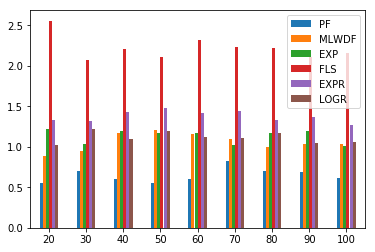

In [47]:
dfGPUTVIDEO120 = pd.DataFrame({'PF': MEGAVIDEO120[1], 'MLWDF': MEGAVIDEO120[2], 'EXP': MEGAVIDEO120[3],
                       'FLS': MEGAVIDEO120[4], 'EXPR': MEGAVIDEO120[5], 'LOGR': MEGAVIDEO120[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVideo120.pdf", bbox_inches='tight')

In [48]:
dfGPUTVIDEO120

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,0.552749,0.890683,1.223174,2.555974,1.326716,1.025141
30,0.696316,0.947186,1.035643,2.070244,1.314067,1.216407
40,0.599623,1.165647,1.194558,2.206221,1.430088,1.096360
50,0.552291,1.212824,1.172257,2.104200,1.476926,1.192349
60,0.606704,1.152994,1.170839,2.312085,1.413934,1.122076
70,0.828200,1.099351,1.023430,2.231758,1.440476,1.102359
80,0.704986,1.002107,1.173448,2.225085,1.331427,1.172292
90,0.684135,1.038409,1.192974,2.106455,1.370838,1.041923
100,0.614991,1.033273,1.012799,2.156250,1.274965,1.053339


# Delay Jitter

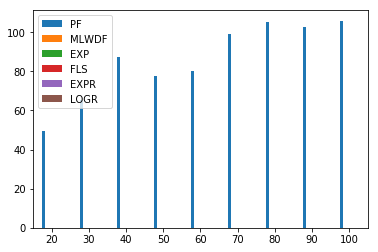

In [49]:
dfDELAYVIDEO120 = pd.DataFrame({'PF': DELAYVIDEO120[1], 'MLWDF': DELAYVIDEO120[2], 'EXP': DELAYVIDEO120[3],
                            'FLS': DELAYVIDEO120[4], 'EXPR': DELAYVIDEO120[5], 'LOGR': DELAYVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideoPF120.pdf", bbox_inches='tight')

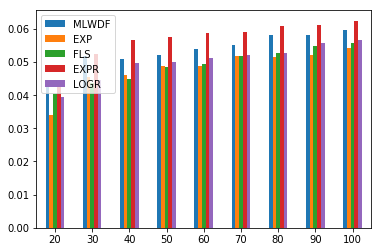

In [50]:
dfDELAYVIDEO120 = pd.DataFrame({'MLWDF': DELAYVIDEO120[2], 'EXP': DELAYVIDEO120[3],
                            'FLS': DELAYVIDEO120[4], 'EXPR': DELAYVIDEO120[5], 'LOGR': DELAYVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideo120.pdf", bbox_inches='tight')

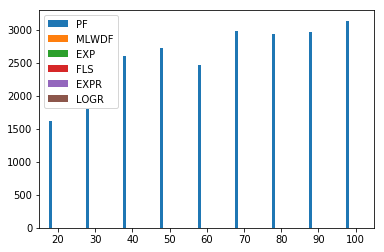

In [51]:
dfJITTERVIDEO120 = pd.DataFrame({'PF': JITTERVIDEO120[1], 'MLWDF': JITTERVIDEO120[2], 'EXP': JITTERVIDEO120[3],
                            'FLS': JITTERVIDEO120[4], 'EXPR': JITTERVIDEO120[5], 'LOGR': JITTERVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideoPF120.pdf", bbox_inches='tight')

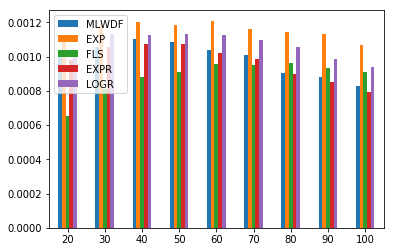

In [52]:
dfJITTERVIDEO120 = pd.DataFrame({'MLWDF': JITTERVIDEO120[2], 'EXP': JITTERVIDEO120[3],
                            'FLS': JITTERVIDEO120[4], 'EXPR': JITTERVIDEO120[5], 'LOGR': JITTERVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideo120.pdf", bbox_inches='tight')

# VIDEO FAIRNESS

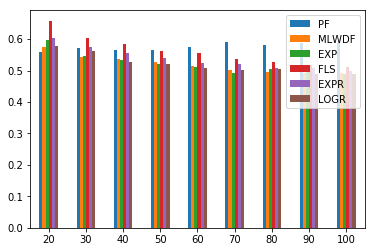

In [53]:
dfFAIRVIDEO120 = pd.DataFrame({'PF': FAIRVIDEO120[1], 'MLWDF': FAIRVIDEO120[2], 'EXP': FAIRVIDEO120[3],
                            'FLS': FAIRVIDEO120[4], 'EXPR': FAIRVIDEO120[5], 'LOGR': FAIRVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfFAIRVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVideo120.pdf", bbox_inches='tight')

In [54]:
dfFAIRVIDEO120

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,0.560336,0.573585,0.596107,0.658465,0.604516,0.579397
30,0.570463,0.543647,0.544720,0.602620,0.574355,0.561796
40,0.566766,0.535579,0.534574,0.584042,0.556774,0.527929
50,0.564820,0.526655,0.520241,0.560694,0.539807,0.521648
60,0.574846,0.513975,0.511186,0.554504,0.523497,0.509495
70,0.590417,0.502481,0.493453,0.537565,0.519765,0.501610
80,0.581397,0.494072,0.506169,0.528430,0.507574,0.503408
90,0.587678,0.492710,0.502976,0.516277,0.507386,0.488527
100,0.588060,0.490892,0.487551,0.510484,0.500150,0.489394


# VOIP GPUT MB/s

In [55]:
MEGAVOIP120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVOICE120:
    MEGAVOIP120[sched] = np.true_divide(GPUTSVOICE120[sched], 8)
MEGAVOIP120

{1: array([0.15069953, 0.22168577, 0.28197888, 0.33003777, 0.34846976,
        0.36398593, 0.38355455, 0.43677953, 0.4668672 ], dtype=float32),
 2: array([0.152064  , 0.228672  , 0.29418752, 0.34995967, 0.39910656,
        0.44007424, 0.48231167, 0.5047194 , 0.53080064], dtype=float32),
 3: array([0.149952  , 0.22331391, 0.2970957 , 0.3583616 , 0.42004737,
        0.44794625, 0.48301312, 0.5116365 , 0.5260621 ], dtype=float32),
 4: array([0.15218432, 0.22923264, 0.30105087, 0.38433024, 0.45524225,
        0.5273626 , 0.585623  , 0.6695014 , 0.69403136], dtype=float32),
 5: array([0.14615808, 0.21924353, 0.29892352, 0.3561344 , 0.42389247,
        0.47143167, 0.51681536, 0.5403597 , 0.5831219 ], dtype=float32),
 6: array([0.15093504, 0.22957824, 0.29456383, 0.3593907 , 0.411712  ,
        0.45421824, 0.48194817, 0.50961405, 0.51735806], dtype=float32)}

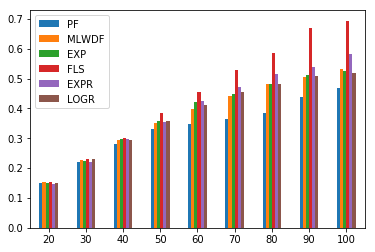

In [56]:
dfGPUTVOICE120 = pd.DataFrame({'PF': MEGAVOIP120[1], 'MLWDF': MEGAVOIP120[2], 'EXP': MEGAVOIP120[3],
                       'FLS': MEGAVOIP120[4], 'EXPR': MEGAVOIP120[5], 'LOGR': MEGAVOIP120[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVoIP120.pdf", bbox_inches='tight')

In [57]:
dfGPUTVOICE120

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,0.150700,0.152064,0.149952,0.152184,0.146158,0.150935
30,0.221686,0.228672,0.223314,0.229233,0.219244,0.229578
40,0.281979,0.294188,0.297096,0.301051,0.298924,0.294564
50,0.330038,0.349960,0.358362,0.384330,0.356134,0.359391
60,0.348470,0.399107,0.420047,0.455242,0.423892,0.411712
70,0.363986,0.440074,0.447946,0.527363,0.471432,0.454218
80,0.383555,0.482312,0.483013,0.585623,0.516815,0.481948
90,0.436780,0.504719,0.511636,0.669501,0.540360,0.509614
100,0.466867,0.530801,0.526062,0.694031,0.583122,0.517358


# Delay Jitter

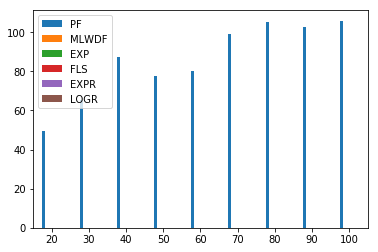

In [58]:
dfDELAYVOICE120 = pd.DataFrame({'PF': DELAYVOICE120[1], 'MLWDF': DELAYVOICE120[2], 'EXP': DELAYVOICE120[3],
                            'FLS': DELAYVOICE120[4], 'EXPR': DELAYVOICE120[5], 'LOGR': DELAYVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIPPF120.pdf", bbox_inches='tight')

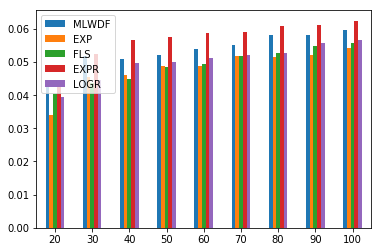

In [59]:
dfDELAYVOICE120 = pd.DataFrame({'MLWDF': DELAYVOICE120[2], 'EXP': DELAYVOICE120[3],
                            'FLS': DELAYVOICE120[4], 'EXPR': DELAYVOICE120[5], 'LOGR': DELAYVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIP120.pdf", bbox_inches='tight')

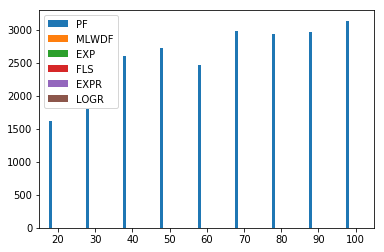

In [60]:
dfJITTERVOICE120 = pd.DataFrame({'PF': JITTERVOICE120[1], 'MLWDF': JITTERVOICE120[2], 'EXP': JITTERVOICE120[3],
                            'FLS': JITTERVOICE120[4], 'EXPR': JITTERVOICE120[5], 'LOGR': JITTERVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIPPF120.pdf", bbox_inches='tight')

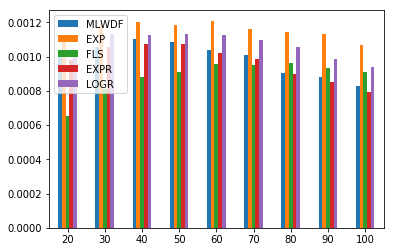

In [61]:
dfJITTERVOICE120 = pd.DataFrame({'MLWDF': JITTERVOICE120[2], 'EXP': JITTERVOICE120[3],
                            'FLS': JITTERVOICE120[4], 'EXPR': JITTERVOICE120[5], 'LOGR': JITTERVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIP120.pdf", bbox_inches='tight')

# Loss Ratio

In [62]:
averagePacketLoss120 = {}
for key in PACKETLOSS120:
    averagePacketLoss120[key] = []
    for i in range(0, 9):
        average = sum(PACKETLOSS120[key][i])/len(PACKETLOSS120[key][i])         
        averagePacketLoss120[key].append(average)

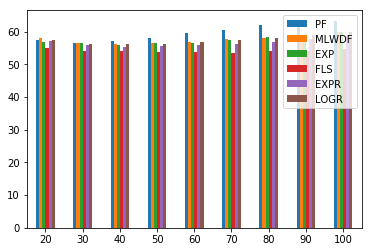

In [63]:
dfLossRatio120 = pd.DataFrame({'PF': averagePacketLoss120[1], 'MLWDF': averagePacketLoss120[2], 'EXP': averagePacketLoss120[3],
                            'FLS': averagePacketLoss120[4], 'EXPR': averagePacketLoss120[5], 'LOGR': averagePacketLoss120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfLossRatio120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio120.pdf", bbox_inches='tight')

In [66]:
dfLossRatio120

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,57.402138,57.968796,56.914978,55.014610,57.122589,57.522346
30,56.707344,56.566162,56.448483,54.176498,55.797913,56.366001
40,57.243793,56.343792,56.004787,53.981426,55.468544,56.350899
50,58.132214,56.468582,56.490967,53.654594,55.497417,56.139874
60,59.614632,56.868713,56.511566,53.849434,55.859844,56.851799
70,60.643360,57.657784,57.498005,53.562763,56.317505,57.394173
80,62.187294,58.200108,58.328545,54.107834,56.938061,58.034649
90,62.610115,59.009384,58.850418,54.026154,57.921478,59.017750
100,63.380363,59.802898,59.882294,54.727791,58.683857,60.050968
